In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn  # Modified Bessel function for equilibrium density

# Model parameters
M = 1e13  # Heavy neutrino mass in GeV
epsilon = 1e-6  # CP asymmetry parameter
K = 10.0  # Decay parameter (ratio of decay rate to Hubble rate at z=1)
g_star = 106.75  # Effective degrees of freedom (Standard Model at high T)
M_pl = 1.22e19  # Planck mass in GeV
sphaleron_conversion = 28/79  # Conversion factor from lepton to baryon asymmetry

# Temperature range (z = M/T)
z_initial = 0.1  # High temperature (T ~ 10*M)
z_final = 100.0  # Low temperature (T ~ M/100)

# Precomputed constant to avoid repeated calculations
H_z1 = np.sqrt(g_star * np.pi**2 / 30) * M**2 / M_pl
Y_N_eq_prefactor = 45 / (4 * np.pi**4 * g_star)

In [9]:
# Functions for the Boltzmann equations - optimized for speed
def H(z):
    """Hubble parameter as a function of z = M/T"""
    return H_z1 / (z**2)

def Y_N_eq(z):
    """Equilibrium density of heavy neutrinos - Approximate formulas for speed"""
    # Non-relativistic approximation for z > 3
    if isinstance(z, np.ndarray):
        result = np.zeros_like(z)
        # For z > 3, use non-relativistic approximation: Y_N_eq ∝ z^(3/2) * exp(-z)
        high_z = z > 3
        result[high_z] = Y_N_eq_prefactor * z[high_z]**(3/2) * np.exp(-z[high_z])
        
        # For z < 3, use simplified Bessel function calculation
        low_z = ~high_z
        if np.any(low_z):
            for i, z_val in enumerate(z[low_z]):
                idx = np.arange(len(z))[low_z][i]
                result[idx] = Y_N_eq_prefactor * z_val**2 * kn(2, z_val)
        return result
    else:
        if z > 3:
            return Y_N_eq_prefactor * z**(3/2) * np.exp(-z)
        else:
            return Y_N_eq_prefactor * z**2 * kn(2, z)

def boltzmann_equations(z, Y):
    """System of Boltzmann equations - optimized for speed"""
    Y_N, Y_L = Y
    
    # Calculate parameters only once
    hz = H(z)
    gamma_D_val = K * H_z1 * M / z  # Decay rate
    Y_N_eq_val = Y_N_eq(z)
    
    # Equation for Y_N - safely handle potential division by zero
    if Y_N_eq_val > 0:
        dY_N_dz = -z/hz * (Y_N/Y_N_eq_val - 1) * gamma_D_val
    else:
        dY_N_dz = -z/hz * gamma_D_val * Y_N
    
    # Calculate washout rate
    if Y_N_eq_val > 0:
        gamma_W_val = gamma_D_val * np.exp(-z) * z**(3/2) / Y_N_eq_val
    else:
        gamma_W_val = 0
    
    # Equation for Y_L
    dY_L_dz = epsilon * z/hz * (Y_N/Y_N_eq_val - 1) * gamma_D_val - z/hz * gamma_W_val * Y_L
    
    return [dY_N_dz, dY_L_dz]

In [10]:
# Initial conditions
Y_N_initial = Y_N_eq(z_initial)  # Start in equilibrium
Y_L_initial = 0.0  # No initial lepton asymmetry

print("Starting simulation...")

# Solve with fewer evaluation points and stiff solver
z_span = (z_initial, z_final)
z_eval = np.logspace(np.log10(z_initial), np.log10(z_final), 500)  # Reduced from 1000

# Use BDF method which is better for stiff problems
solution = solve_ivp(
    boltzmann_equations, 
    z_span, 
    [Y_N_initial, Y_L_initial], 
    method='BDF',  # Better for stiff problems
    t_eval=z_eval,
    rtol=1e-4,     # Relaxed tolerance (was 1e-6)
    atol=1e-7      # Relaxed tolerance (was 1e-9)
)

print("Simulation completed!")

# Extract results
z_values = solution.t
Y_N_values = solution.y[0]
Y_L_values = solution.y[1]
Y_N_eq_values = Y_N_eq(z_values)

# Calculate final baryon asymmetry
final_lepton_asymmetry = Y_L_values[-1]
final_baryon_asymmetry = -sphaleron_conversion * final_lepton_asymmetry

print(f"Final lepton asymmetry: {final_lepton_asymmetry:.2e}")
print(f"Final baryon asymmetry: {final_baryon_asymmetry:.2e}")
print(f"Observed baryon asymmetry in universe: ~6e-10")

Starting simulation...
Simulation completed!
Final lepton asymmetry: -2.68e-24
Final baryon asymmetry: 9.49e-25
Observed baryon asymmetry in universe: ~6e-10


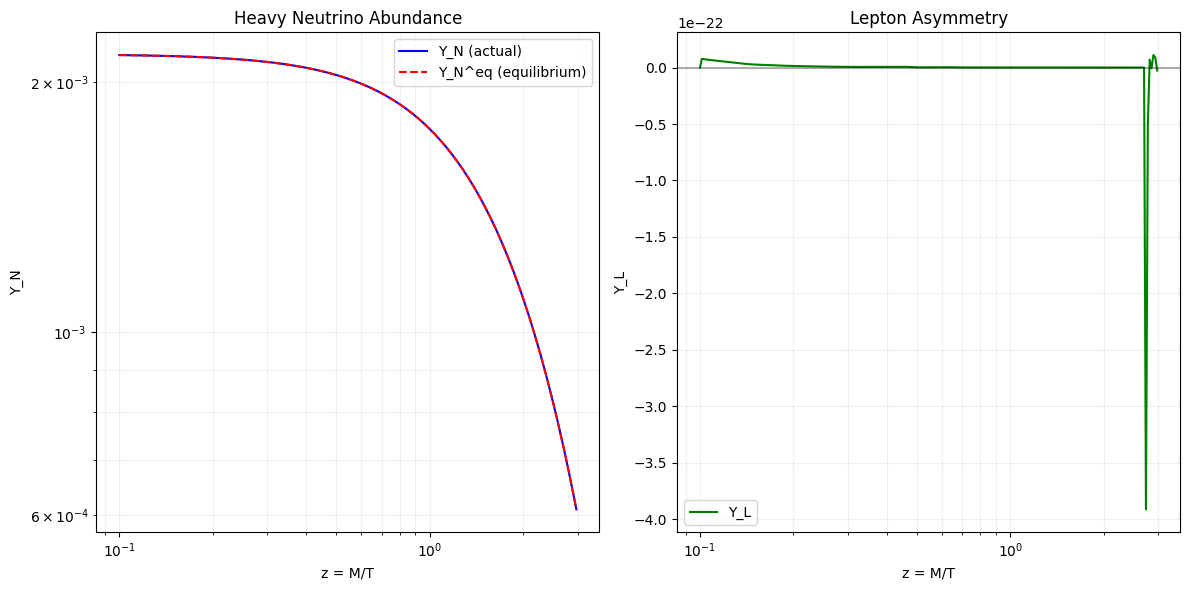

In [11]:

# Create plots
plt.figure(figsize=(12, 6))

# Plot neutrino abundance
plt.subplot(1, 2, 1)
plt.loglog(z_values, Y_N_values, 'b-', label='Y_N (actual)')
plt.loglog(z_values, Y_N_eq_values, 'r--', label='Y_N^eq (equilibrium)')
plt.xlabel('z = M/T')
plt.ylabel('Y_N')
plt.title('Heavy Neutrino Abundance')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# Plot lepton asymmetry
plt.subplot(1, 2, 2)
plt.semilogx(z_values, Y_L_values, 'g-', label='Y_L')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('z = M/T')
plt.ylabel('Y_L')
plt.title('Lepton Asymmetry')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

plt.tight_layout()
plt.show()